# Non-Negative Matrix Factorization applications.

In this notebook we try to use our implementations of Non-Negative Matrix Factorization for three purposes :
    - a simple analysis of our implementations
    - a recommender algorithm for movies based on users ratings of different movies
    - faces recognition

We implemented the two algorithms presented in 'Algorithms for Non-negative Matrix Factorization' which respectively try to minimize  :
    - Kullback-Leibler divergence (see kul_mul.py)
    - Frobenius distance (see fro_mul.py)
    
The codes (kul_mul.py and fro_mul.py) were written using the most possible matrix products in order to ensure a fast computation.

In [5]:
import numpy as np
import scipy.io as sio
import numpy as np
from kul_mul import *
from fro_mul import *
from monitor import *
import pandas as pd
from IPython.display import Image

/anaconda3/envs/ML/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Analysis of the NMF implementations

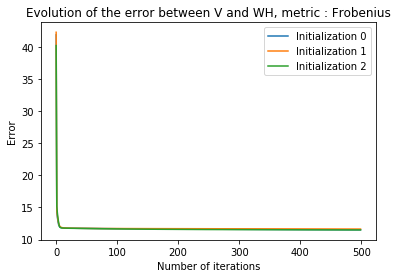

In [5]:
# Sensitivity to initialization for the algo minimizing Frobenius distance
r = 5
n = 1000
p = 100
V = np.random.rand(n, p)
to_compare = []
amps = [1, 10, 20]
for i in range(len(amps)):
    W_init, H_init = amps[i]*np.random.rand(n, r), amps[i]*np.random.rand(r, p)
    froNMF = FrobeniusNMF(V=V,r=r, W_init=W_init, H_init=H_init)
    to_compare.append(froNMF)

monitor_fro = Monitor(algos=to_compare, metric = 'Frobenius', niter=500)
monitor_fro.plot_error(labels = ['Initialization ' + str(i) for i in range(len(amps))])

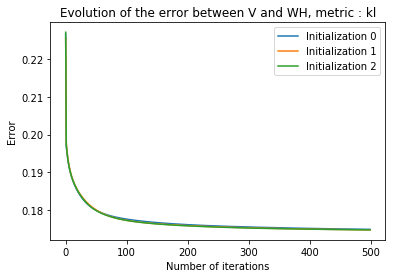

In [66]:
# Sensitivity to initialization for the algo minimizing Kullbach-Leibler divergence
r = 7
n = 1000
p = 100
V = np.random.rand(n, p)
to_compare_kl = []
amps = [1, 10, 20]
for i in range(len(amps)):
    W_init, V_init = amps[i]*np.random.rand(n, r), amps[i]*np.random.rand(r, p)
    kNMF = KullbachNMF(V=V,r=r)
    to_compare_kl.append(kNMF)

monitor_kl = Monitor(algos=to_compare_kl, metric = 'kl', niter=500)
monitor_kl.plot_error(labels = ['Initialization ' + str(i) for i in range(len(amps))])

In [7]:
# comparing the different solutions provided for each initialization
for i in range(len(monitor_fro.algos)) :
    for j in range(i + 1, len(monitor_fro.algos)) :
        print('Frobenius norm between the results after initializations {} and {}'.format(i,j),
              np.linalg.norm(monitor_fro.algos[i].V_hist[-1] - monitor_fro.algos[j].V_hist[-1]))

Frobenius norm between the results after initializations 0 and 1 24.260865787989108
Frobenius norm between the results after initializations 0 and 2 20.599928454086356
Frobenius norm between the results after initializations 1 and 2 22.587990921510112


## Comparison of our NMF with sklearn's NMF

The first thing to notice is that our two algos, minimizing respectively the frobenius norm and the Kulbach-Leibler divergence make them decrease at each step.

However, by initializing differently W and H, we could expect that the algos converge towards different solutions since theory guarantees that the algos converge towards a local minima and not a global one.

In [69]:
'''sklearn implements an NMF in its module sklearn.decomposition, let s compare it with our own implementation. 
The distance to minimize used in sklearn s nmf is the Frobenius norm, so we compare it to our 
implementation FroNMF. Sklearn implements two solvers : multiplicative updates (which is ours) and coordinate 
descent.
We realize a certain number of tests (here 20) and compute the average error between the real V and W @ H 
for sklearn and for our solver.
'''

from sklearn.decomposition import NMF

r = 10
n = 1000
p = 100
niter = 200
tests = 20
errors = {}
errors['sklearn'] = []
errors['FrobeniusNMF'] = []
for _ in range(tests) :
    V = np.random.rand(n, p)
    nmf_sk = NMF(n_components=r, solver='mu')
    fro_nmf = FrobeniusNMF(V = V, r=r)
    W_sk = nmf_sk.fit_transform(V)
    H_sk = nmf_sk.components_
    fro_nmf.train(niter = 200, verbose = False)
    errors['sklearn'].append(np.linalg.norm(V - W_sk @ H_sk))
    errors['FrobeniusNMF'].append(np.linalg.norm(V - fro_nmf.w_hist[-1] @ fro_nmf.h_hist[-1]))
    
print('Mean error (Frobenius) for sklearn implementation : {}'.format(np.mean(errors['sklearn'])))
print('Mean error (Frobenius) for the FrobeniusNMF implementation : {}'.format(np.mean(errors['FrobeniusNMF'])))

Mean error (Frobenius) for sklearn implementation : 85.91436953633269
Mean error (Frobenius) for the FrobeniusNMF implementation : 84.8561270342711


$\textbf{Remarks :}$

That is quite reassuring concerning our implementation of the NMF.

## Application of Non-Negative Matrix Factorization to Recommender System

NMF is well known to perform in the context of recommender systems as the Netflix challenge which aimed at finding an algo recommending movies to a user based on its previous ratings showed it.

The dataset studied here is taken from https://grouplens.org/datasets/movielens/ . It is a dataset composed of 1M ratings of 4000 movies by 6000 users.
There are actually three datasets :
    - the ratings containing the UserID, the MovieID and the rating of each user for that movie.
    - the users list containing information on each user, that we don't use here.
    - the movies list containing information on each movie (it relates the movie ID to more general information).
    
Basically, what we want to do here is a matrix completion : if we look at the matrix containing all the users ratings for all movies, some cells are empty (because a user has not seen and rated every movie in the database). The idea is to reconstruct the rating he would give to suggest him movies that he would like.
    

In [3]:
ratings_list = [i.strip().split("::") for i in open('data/ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('data/ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('data/ml-1m/movies.dat', 'r', errors='ignore').readlines()]

In [6]:
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [7]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
print(ratings_df.shape)

(1000209, 4)


In [9]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
print(movies_df.shape)

(3883, 3)


In the next cell, we build a Dataframe containing :
    - UserID's as rows
    - MovieID's as columns
so that the cell $df[i,j]$ contains the rating of user $i$ for movie $j$.
When user $i$ has not rated movie j, we put a 0 in $df[i,j]$

In [18]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


$\textbf{Remark:}$

In order that each user has the same distribution for the ratings (at least the same mean, we need to rescale them)

In [19]:
from sklearn.preprocessing import MinMaxScaler
nrows, ncols = R_df.shape
scaler = MinMaxScaler()
# We transpose R_df because otherwise the scaler scales the features i.e each movie rating.
R_scaled_transposed = scaler.fit_transform(R_df.T)
R_scaled = R_scaled_transposed.T

In [20]:
print('nrows: ', nrows)
print('ncols: ', ncols)

nrows:  6040
ncols:  3706


In [21]:
print(R_scaled)

[[1.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.6 0.  0.  ... 0.  0.  0. ]]


## Factorization

In [22]:
niter = 100
r = 50
froNMF = FrobeniusNMF(V=R_scaled, r=r)
froNMF.train(niter=niter, verbose=True)
W, H = froNMF.W, froNMF.H

Iter n° 0
Iter n° 10
Iter n° 20
Iter n° 30
Iter n° 40
Iter n° 50
Iter n° 60
Iter n° 70
Iter n° 80
Iter n° 90


In [23]:
print('Shape of W : ', W.shape)
print('Shape of H : ',H.shape)

Shape of W :  (6040, 50)
Shape of H :  (50, 3706)


We are now able to get all the users' predicted ratings :

In [28]:
predicted_ratings = W @ H
# We rescale the predicted_ratings :
predicted_ratings_transposed = scaler.inverse_transform(predicted_ratings.T)
predicted_ratings = pd.DataFrame(np.around(predicted_ratings_transposed.T, 3), columns=R_df.columns)

In [29]:
predicted_ratings.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.632,0.256,0.057,0.054,0.001,0.008,0.014,0.085,0.000,0.042,...,0.000,0.002,0.026,0.000,0.000,0.165,0.001,0.001,0.000,0.000
1,0.383,0.310,0.401,0.042,0.016,0.902,0.041,0.012,0.271,1.458,...,0.001,0.000,0.001,0.073,0.036,0.139,0.001,0.022,0.001,0.057
2,2.016,0.361,0.138,0.006,0.033,0.215,0.008,0.011,0.052,0.536,...,0.001,0.000,0.004,0.016,0.000,0.171,0.031,0.007,0.002,0.001
3,0.097,0.002,0.038,0.001,0.000,0.347,0.000,0.001,0.000,0.010,...,0.003,0.000,0.000,0.001,0.000,0.010,0.026,0.006,0.006,0.000
4,0.959,0.038,0.094,0.089,0.022,1.670,0.113,0.035,0.000,0.165,...,0.141,0.000,0.005,0.035,0.008,0.120,0.944,0.184,0.195,0.239


In [34]:
'''Given a UserID, we recommend num_recommendations in the movies he has not seen yet. These movies are supposed to 
be the best fit for him according to our model'''
def recommend(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5) :
    user_row_number = userID - 1
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    sorted_movie_id = sorted_user_predictions
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )
    print('User {} has already rated {} movies.'.format(userID, user_full.shape[0]))
    print('Recommending the highest {} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['MovieID'].isin(user_full['MovieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )
    return user_full, recommendations

In [35]:
user_full, recommendations = recommend(predicted_ratings, userID=32, movies_df=movies_df, original_ratings_df=ratings_df)

User 32 has already rated 48 movies.
Recommending the highest 5 predicted ratings movies not already rated.


In [36]:
recommendations

,MovieID,Title,Genres
286,296,Pulp Fiction (1994),Crime|Drama
308,318,"Shawshank Redemption, The (1994)",Drama
104,110,Braveheart (1995),Action|Drama|War
513,527,Schindler's List (1993),Drama|War
1178,1213,GoodFellas (1990),Crime|Drama


In [37]:
user_full

,UserID,MovieID,Rating,Timestamp,Title,Genres
22,32,32,5,978121599,Twelve Monkeys (1995),Drama|Sci-Fi
25,32,3072,5,978118683,Moonstruck (1987),Comedy
45,32,2108,5,978122598,L.A. Story (1991),Comedy|Romance
16,32,1296,5,978122520,"Room with a View, A (1986)",Drama|Romance
40,32,2020,5,978121545,Dangerous Liaisons (1988),Drama|Romance
27,32,3147,5,978123863,"Green Mile, The (1999)",Drama|Thriller
8,32,593,5,978123515,"Silence of the Lambs, The (1991)",Drama|Thriller
21,32,2762,5,978121626,"Sixth Sense, The (1999)",Thriller
29,32,3079,5,978122813,Mansfield Park (1999),Drama
30,32,2858,4,978119364,American Beauty (1999),Comedy|Drama


# Application of Non-Negative Matrix Factorization to Face Recognition

Two interpretations are possible in the context of NMF for Face recognition :
    - Usually, in ML our matrices shapes are (n_samples, n_features) which would correspond here to "each line correspond to the pixels values of a person'. Doing a NMF then allows us to write each person of the database as a linear combination of r people.
    - the other point of view is to transpose the matrix. Doing a NMF will then allow us to write each pixel at a specific location in each image as a linear combination of r pixels (See image below).

Here, first we adopt the first point of view and compare it to a well known feature extractor (PCA) and then we adopt the second point of view.
For the two points of view, to see if our NMF is well realized, we train a K-Nearest Neighbors Classifier on the weights given for each feature by the NMF. 

### A look at the dataset and some preprocessing

In [38]:
import scipy.io as sio
import scipy.misc as smp
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

The dataset we use here is composed of 10 different face pictures of 40 different people.
The idea here is to build a classifier based on Non Negative Matrix factorization for face recognition.


(112, 92, 3)


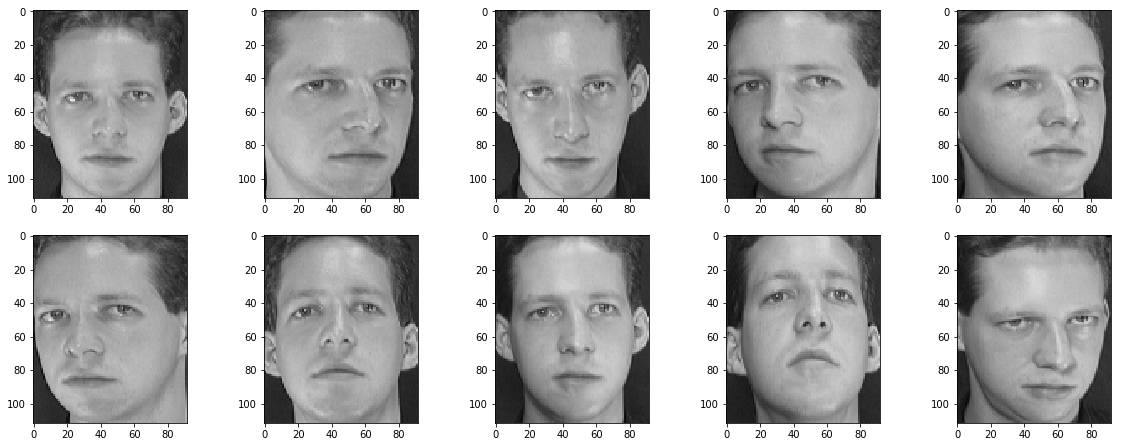

In [39]:
# Let's see some images from the dataset
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11) :
    img = cv2.imread('data/orl_faces/s1/{}.pgm'.format(i))
    fig.add_subplot(5, 5, i)
    plt.imshow(img)
print(img.shape)

In [41]:
'''We first build a train and test set : we select 7 pictures for each individual for the train set and keep the 
3 others for the test set. We keep in memory a number for each picture which represent the subject.
For computational purposes we reduce the size of the images to (32, 32)
We use open cv to convert our images to gray scale and resize them'''

def build_sets(path, new_shape = (32, 32), train_size = 7):
    x_tr = np.zeros((train_size*40, new_shape[0]*new_shape[1]))
    y_tr = []
    x_te = np.zeros(((10-train_size)*40, new_shape[0]*new_shape[1]))
    y_te = []
    ind_tr = 0
    ind_te = 0
    for i in range(1, 41) :
        for j in range(1, 11) :
            img = cv2.imread(path + '/orl_faces/s{}/{}.pgm'.format(i, j))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, new_shape)
            img = img.reshape((new_shape[0]*new_shape[1]))
            if j <= train_size :
                x_tr[ind_tr, :] = img
                y_tr.append(i)
                ind_tr += 1
            else :
                x_te[ind_te, :] = img
                y_te.append(i)
                ind_te += 1
    return x_tr/255., x_te/255., np.array(y_tr), np.array(y_te)

### First point of view : each line correspond to the picture of a person

In [42]:
'''We now have 4 datasets :
    - x_tr/te where rows number i correspond to a 32*32 image of a patient
    - y_tr/te where the ith element answers the question : which face is it'''

from sklearn.utils import shuffle

x_tr, x_te, y_tr, y_te = build_sets(path='data/')
x_tr, y_tr = shuffle(x_tr, y_tr)
x_te, y_te = shuffle(x_te, y_te)

In [43]:
import seaborn as sns

In [49]:
'We do a TSNE to have an idea of the data representation in 2D'
from sklearn.manifold import TSNE
x_tr_embedded = TSNE().fit_transform(x_tr)

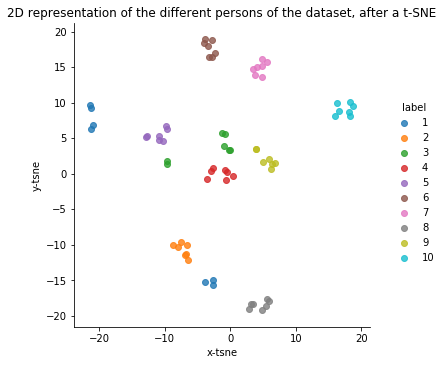

In [50]:
'We only keep 10 different persons in order to have a clearer representation and for computational purposes.'
df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = x_tr_embedded[y_tr <= 10,0]
df_tsne['y-tsne'] = x_tr_embedded[y_tr<= 10,1]
df_tsne['label'] = y_tr[y_tr<=10]

sns.lmplot(x='x-tsne', y = 'y-tsne', fit_reg=False, data=df_tsne, hue='label')
plt.title('2D representation of the different persons of the dataset, after a t-SNE')
plt.show()


In [51]:
print(x_tr.shape)

(280, 1024)


In [52]:
'''We are now ready to proceed to the NMF decomposition of x_tr'''
niter = 200
froNMF = FrobeniusNMF(V=x_tr, r=30)
froNMF.train(niter = niter, verbose = False)
print('NMF with Frobenius norm done')
#
kulNMF = KullbachNMF(V=x_tr, r=30)
kulNMF.train(niter = niter, verbose = False)
print('NMF with kulbach divergence done')

NMF with Frobenius norm done
NMF with kulbach divergence done


In [53]:
# To evaluate our nmf on the test set we need to rebuild W_te thanks to H_tr and x_te
def build_W_te(h_tr, x_te) :
    h_tr_ = h_tr.copy()
    h_tr_pinv = np.linalg.pinv(h_tr_)
    w_te = x_te @ h_tr_pinv
    return w_te

In [54]:
W_tr_fro, H_tr_fro = froNMF.W, froNMF.H
W_tr_kul, H_tr_kul = kulNMF.W, kulNMF.H

In [55]:
W_te_kul = build_W_te(H_tr_kul, x_te)
W_te_fro = build_W_te(H_tr_fro, x_te)

In [56]:
from sklearn.neighbors import KNeighborsClassifier

clf_fro = KNeighborsClassifier(n_neighbors=1)
clf_fro.fit(W_tr_fro, y_tr)
clf_kul = KNeighborsClassifier(n_neighbors=1)
clf_kul.fit(W_tr_kul, y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [60]:
print('Predicted classes for the classifiers based on the two NMF :', '\n')
print('Frobenius NMF :', clf_fro.predict(W_te_fro))
print('Kullback NMF :',clf_kul.predict(W_te_kul))

Predicted classes for the classifiers based on the two NMF : 

Frobenius NMF : [26 33 13 39 37 22 39 35 34  8  3 12 10 22 31  4 40 20 38 14  8 36  3 39
  4 11 12 16  2 23 24 18  6  2 14 40 25 28 38 36 37 30 25  8  7  2  3 17
 16 22 40  5 35 32 32  4 31 27 19 20 21  9  8 20 23 24 13 21  5 26 14 32
  1 30 29  9 34 27 40 28 17 19 34 27 21 23 11 18  6 24 37 26  1  9  7  7
  6 31 16 37  1 38 36 10 18 15 29 30 25 14 11 39 17 12 15 15 35 33 33 13]
Kullback NMF : [26 33 13 29 37 22 39 35 34  8  3 12 10 22 31  4 40 20 38 14  8 36  3 39
  4 11 12 16  2 23 24 18  6  2 14 40 25 28 38 36 37 30 25  8  7  2  3 17
  3 22 40  5 35 32 32  4 31 27 19 20 21  9  8 20 23 24 13 21  5 26 14 32
 17 30 29  9 34 27 40 28 17 19 34 27 21 23 11 18  6 24 37 26  1  9  7  7
  6 31 16 37 24 38 36 10 18 15 29 30 25 11 11 39 17 12 15 15 35 33 33 13]


In [61]:
print('Accuracy with Frobenius norm', clf_fro.score(W_te_fro, y_te))
print('Accuracy with Kulbach divergence', clf_kul.score(W_te_kul, y_te))

Accuracy with Frobenius norm 0.9583333333333334
Accuracy with Kulbach divergence 0.9416666666666667


## Comparison of NMF with a PCA

In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
x_tr_pca = pca.fit_transform(x_tr)
x_te_pca = pca.transform(x_te)

In [63]:
print(x_tr_pca.shape)

(280, 10)


In [64]:
clf_pca = KNeighborsClassifier(n_neighbors = 1)
clf_pca.fit(x_tr_pca, y_tr)
print('Score with PCA : ', clf_pca.score(x_te_pca, y_te))

Score with PCA :  0.95


In [65]:
def plot_results(ranks = [5, 10, 15, 20, 30, 50, 75, 100, 150, 200]) :
    pca_results = []
    nmf_results = {}
    nmf_results['fro'] = []
    nmf_results['kul'] = []
    for r in ranks :
        niter = 200
        froNMF = FrobeniusNMF(V=x_tr, r=r)
        froNMF.train(niter = niter, verbose = False)
        kulNMF = KullbachNMF(V=x_tr, r=r)
        kulNMF.train(niter = niter, verbose = False)
        ###
        W_tr_fro, H_tr_fro = froNMF.W, froNMF.H
        W_te_fro = build_W_te(h_tr=H_tr_fro, x_te=x_te)
        W_tr_kul, H_tr_kul = kulNMF.W, kulNMF.H
        W_te_kul = build_W_te(h_tr=H_tr_kul, x_te=x_te)
        ###
        clf_fro = KNeighborsClassifier(n_neighbors=1)
        clf_fro.fit(W_tr_fro, y_tr)
        clf_kul = KNeighborsClassifier(n_neighbors=1)
        clf_kul.fit(W_tr_kul, y_tr)
        nmf_results['fro'].append(clf_fro.score(W_te_fro, y_te))
        nmf_results['kul'].append(clf_kul.score(W_te_kul, y_te))
        pca = PCA(n_components = r)
        x_tr_pca = pca.fit_transform(x_tr)
        x_te_pca = pca.transform(x_te)
        clf_pca = KNeighborsClassifier(n_neighbors=1)
        clf_pca.fit(x_tr_pca, y_tr)
        pca_results.append(clf_pca.score(x_te_pca, y_te))
    plt.plot(ranks, nmf_results['fro'], color = 'r', label = 'NMF Frobenius norm')
    plt.plot(ranks, nmf_results['kul'], color = 'b', label = 'NMF Kulback divergence')
    plt.plot(ranks, pca_results, color = 'g', label = 'PCA')
    plt.legend()
    plt.title('Comparison between PCA and NMF for faces recognition')
    plt.show()
    return

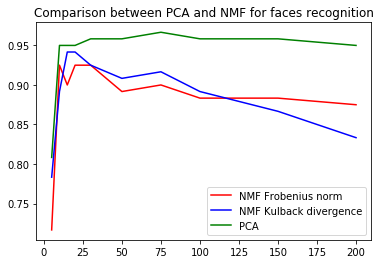

In [66]:
plot_results()

### Second point of view : each line i corresponds to the pixels of each image in i th position

The second point of view that we are going to look at is clearly the one that makes more sense. We find facial features thanks to the NMF and each face is then explain by the importandce that these features have on that face.
This model is more robust, especially if new faces are added to the dataset.

Visual explanation :


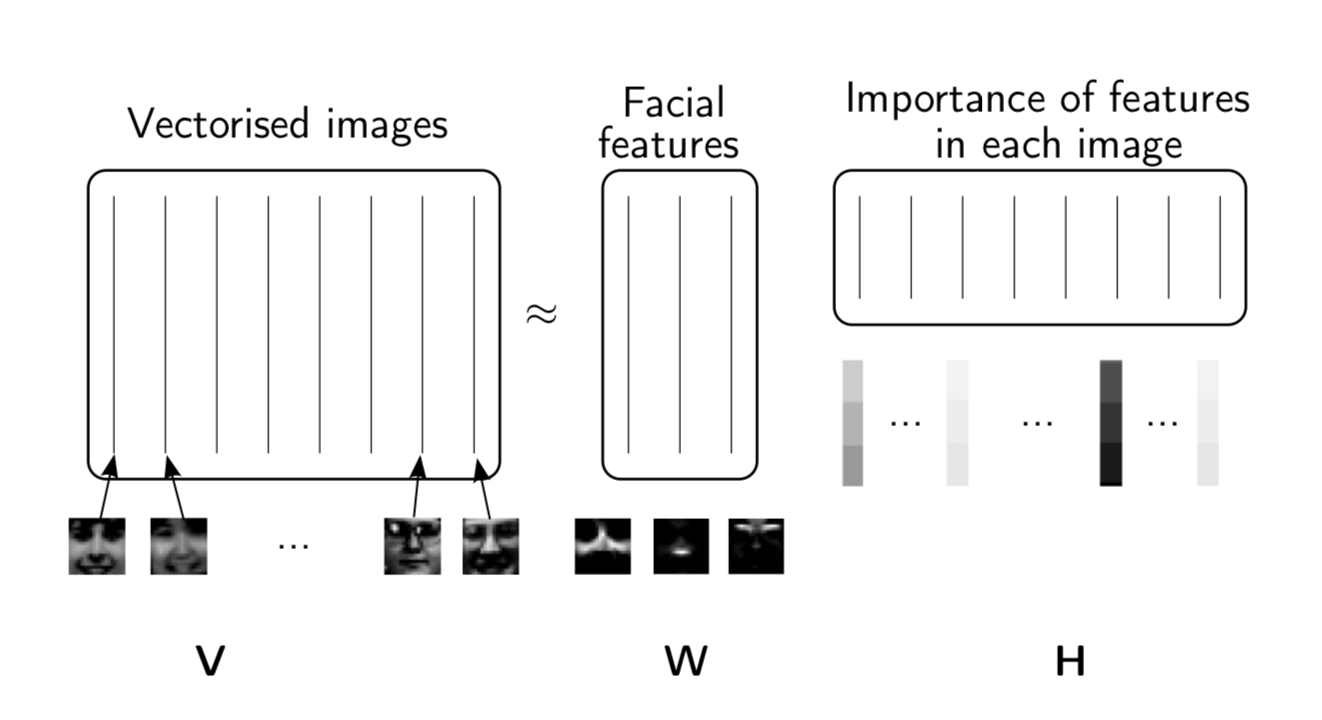

In [67]:
print('Visual explanation :')
Image(filename='./img/NMF explained.png')

In [77]:
x_tr, x_te = x_tr.T, x_te.T

In [78]:
print('New shape of x_tr :', x_tr.shape)
print('New shape of x_te :', x_te.shape)

New shape of x_tr : (1024, 280)
New shape of x_te : (1024, 120)


In [81]:
niter = 200
kulNMF = KullbachNMF(V=x_tr, r=20)
kulNMF.train(niter = niter, verbose = False)
print('NMF with kullbach divergence done')

NMF with kullbach divergence done


In [83]:
W_tr_kul, H_tr_kul = kulNMF.W, kulNMF.H
print('W_tr shape :', W_tr_kul.shape, ', H_tr shape : ', H_tr_kul.shape)

W_tr shape : (1024, 20) , H_tr shape :  (20, 280)


(32, 32)


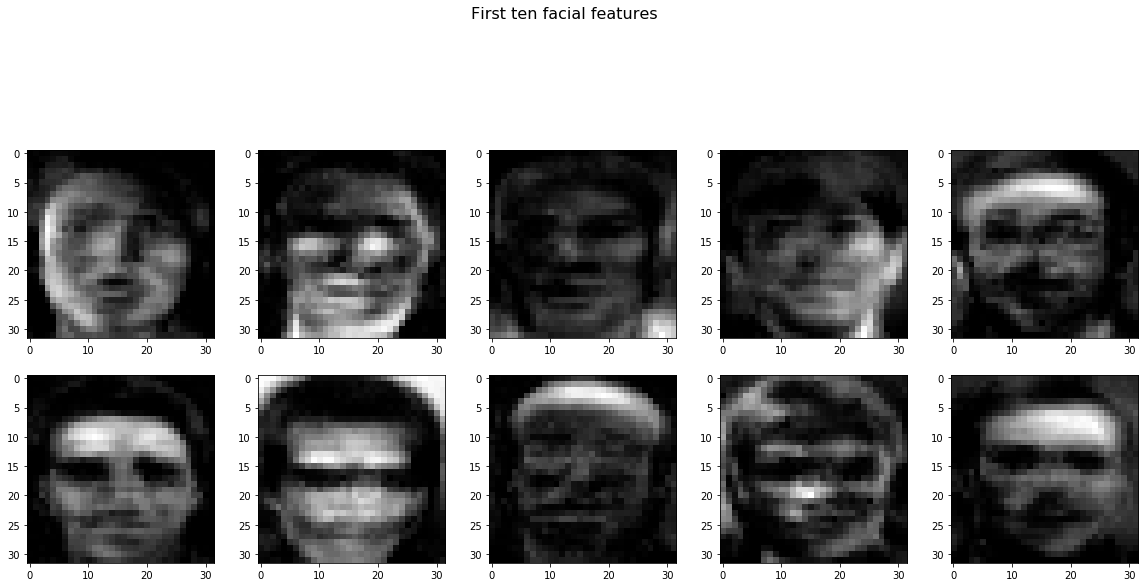

In [85]:
'Let s have a look at some facial features :'
fig = plt.figure(figsize=(20, 20))
fig.suptitle('First ten facial features', fontsize = 16)
for i in range(1, 11) :
    img = W_tr_kul[:,i].reshape((32, 32))
    fig.add_subplot(5, 5, i)
    plt.imshow(img, cmap = 'gray')
print(img.shape)

In [86]:
def build_H_te(W_tr, x_te) :
    w_tr_pinv = np.linalg.pinv(W_tr)
    h_te = w_tr_pinv @ x_te
    return h_te

In [87]:
H_te_kul = build_H_te(W_tr_kul, x_te)

In [88]:
print('H_te shape : ', H_te_kul.shape)

H_te shape :  (20, 120)


In [89]:
'''To evaluate our decomposition, we train a k-nn on the weights given to each feature for each sample (i.e H_te)'''
from sklearn.neighbors import KNeighborsClassifier

knn_hte = KNeighborsClassifier(n_neighbors=1)
knn_hte.fit(H_tr_kul.T, y_tr)
print('Score (accuracy) : ', knn_hte.score(H_te_kul.T, y_te))

Score (accuracy) :  0.9333333333333333


In [90]:
'''Running this cell several time will show that the score is highly dependant on the initialization'''
for r in [5, 10, 20, 50, 100] :
    niter = 500
    kulNMF = KullbachNMF(V=x_tr, r=r)
    kulNMF.train(niter = niter, verbose = False)
    W_tr_kul, H_tr_kul = kulNMF.W, kulNMF.H
    H_te_kul = build_H_te(W_tr_kul, x_te)
    knn_hte = KNeighborsClassifier(n_neighbors=1)
    knn_hte.fit(H_tr_kul.T, y_tr)
    print('Accuracy (r = {}): '.format(r), knn_hte.score(H_te_kul.T, y_te))

Accuracy (r = 5):  0.7416666666666667
Accuracy (r = 10):  0.925
Accuracy (r = 20):  0.9416666666666667
Accuracy (r = 50):  0.9083333333333333
Accuracy (r = 100):  0.8666666666666667


In [93]:
for r in [5, 10, 20, 50, 100] :
    niter = 500
    froNMF = FrobeniusNMF(V=x_tr, r=r)
    froNMF.train(niter = niter, verbose = False)
    W_tr_fro, H_tr_fro = froNMF.W, froNMF.H
    H_te_fro = build_H_te(W_tr_fro, x_te)
    knn_hte = KNeighborsClassifier(n_neighbors=1)
    knn_hte.fit(H_tr_fro.T, y_tr)
    print('Accuracy (r = {}): '.format(r), knn_hte.score(H_te_fro.T, y_te))

Accuracy (r = 5):  0.7166666666666667
Accuracy (r = 10):  0.875
Accuracy (r = 20):  0.95
Accuracy (r = 50):  0.9083333333333333
Accuracy (r = 100):  0.8666666666666667


$\textbf{Conclusion}$

In this notebook, we have :
    - checked our implementations of the two NMF. We checked that the distance to $V$ was always decreasing after each iteration and compared our implementation minimizing the Frobenius Norm with sklearn's implementation. Ours was slightly better.
    - studied the influence of the initialization on the NMF convergence. On the simulated dataset we didn't see much influence. However, on the face recognition dataset (see cell  above) the performance is influenced a lot by the initialization.
    - applied our implementations to a recommender system : the implementation is quite simple but performs well on the movie lens dataset.
    - applied our implementations to a face recognition issue. The results are comparable to the ones obtained by a feature selection by PCA : that is a little disappointing.
    
Ideas for improvement :
    - find the optimal $r$ for the NMF by cross validation should improve results.
    - use a more powerful machine that could allow us not to resize the images.
    - compare our movie recommender system to other methods such as movies and users embeddings.
    
